# A/B test for an online store <a class="tocSkip">

It is necessary to analyze A/B test results (`orders` and `visitors` datasets).

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import warnings

In [57]:
pd.options.display.float_format = '{: .2f}'.format
plt.rcParams.update({'font.size': 13})
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

## Data preprocessing

### `Orders` data

In [3]:
orders = pd.read_csv('datasets/orders.csv')
orders.info()
orders.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
878,3315359627,1831956319,2019-08-05,90,A
286,3508803238,3117119809,2019-08-24,19260,A
1072,3559692217,2306096143,2019-08-12,1780,A
177,790091309,1387624577,2019-08-17,2750,B
268,3897826085,3927376365,2019-08-18,10450,B


The `group` column is the A/B test group that the order belongs to.

In [5]:
print('Number of duplicates:', orders.duplicated().sum())

Number of duplicates: 0


In [13]:
orders['date'] = pd.to_datetime(
    orders['date'], 
    format='%Y-%m-%d')
orders.dtypes

transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                    object
dtype: object

In [8]:
orders['date'].describe(datetime_is_numeric=True)

count                             1197
mean     2019-08-15 13:06:46.015037696
min                2019-08-01 00:00:00
25%                2019-08-08 00:00:00
50%                2019-08-15 00:00:00
75%                2019-08-23 00:00:00
max                2019-08-31 00:00:00
Name: date, dtype: object

### `Visitors` data

In [11]:
visitors = pd.read_csv('datasets/visitors.csv')
visitors.info()
visitors.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
51,2019-08-21,B,656
59,2019-08-29,B,531
2,2019-08-03,A,507
33,2019-08-03,B,509
43,2019-08-13,B,769


The `group` column is the A/B test group that the order belongs to.

The `visitors` column is the number of users on the specified date in the specified A/B test group. 

In [12]:
print('Number of duplicates:', visitors.duplicated().sum())

Number of duplicates: 0


In [14]:
visitors['date'] = pd.to_datetime(
    visitors['date'], 
    format='%Y-%m-%d')
visitors.dtypes

date        datetime64[ns]
group               object
visitors             int64
dtype: object

In [15]:
visitors['date'].describe(datetime_is_numeric=True)

count                     62
mean     2019-08-16 00:00:00
min      2019-08-01 00:00:00
25%      2019-08-08 06:00:00
50%      2019-08-16 00:00:00
75%      2019-08-23 18:00:00
max      2019-08-31 00:00:00
Name: date, dtype: object

## Cumulative indicators<a id="2.2"></a>

Let's explore the cumulative revenue and the average check.

In [16]:
datesGroups = (
    orders[['date','group']]
    .drop_duplicates())
ordersAggregated = (
    datesGroups.apply(
        lambda x: orders[np.logical_and(
            orders['date'] <= x['date'], 
            orders['group'] == x['group'])]
        .agg({'date' : 'max', 
              'group' : 'max', 
              'transactionId' : pd.Series.nunique, 
              'visitorId' : pd.Series.nunique, 
              'revenue' : 'sum'}), 
        axis=1)
    .sort_values(by=['date',
                     'group']))
visitorsAggregated = (
    datesGroups.apply(
        lambda x: visitors[np.logical_and(
            visitors['date'] <= x['date'], 
            visitors['group'] == x['group'])]
        .agg({'date' : 'max', 
              'group' : 'max', 
              'visitors' : 'sum'}), 
        axis=1)
    .sort_values(by=['date','group']))

In [17]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, 
    left_on=['date', 'group'], 
    right_on=['date', 'group'])
cumulativeData.columns = ['date', 
                          'group', 
                          'orders', 
                          'buyers', 
                          'revenue', 
                          'visitors']
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

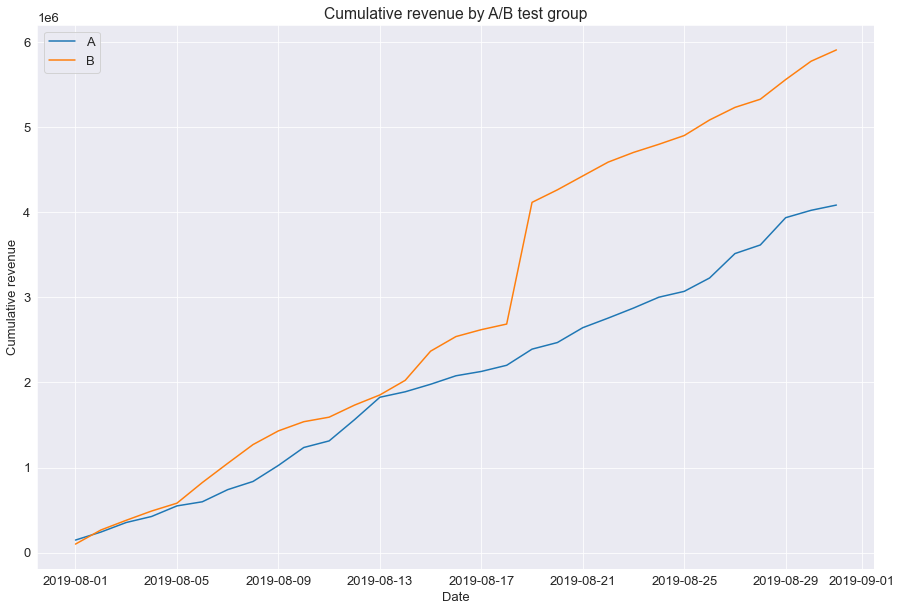

In [30]:
plt.figure(figsize=(15,10))
plt.plot(
    cumulativeRevenueA['date'], 
    cumulativeRevenueA['revenue'], 
    label='A')
plt.plot(
    cumulativeRevenueB['date'], 
    cumulativeRevenueB['revenue'], 
    label='B')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative revenue')
plt.title('Cumulative revenue by A/B test group')
plt.show()

Revenue increases almost uniformly throughout the test in group A, with group B showing a single spike. This may indicate either a surge in the number of orders, or the presence of very expensive orders on this date. We will return to this when analyzing outliers.

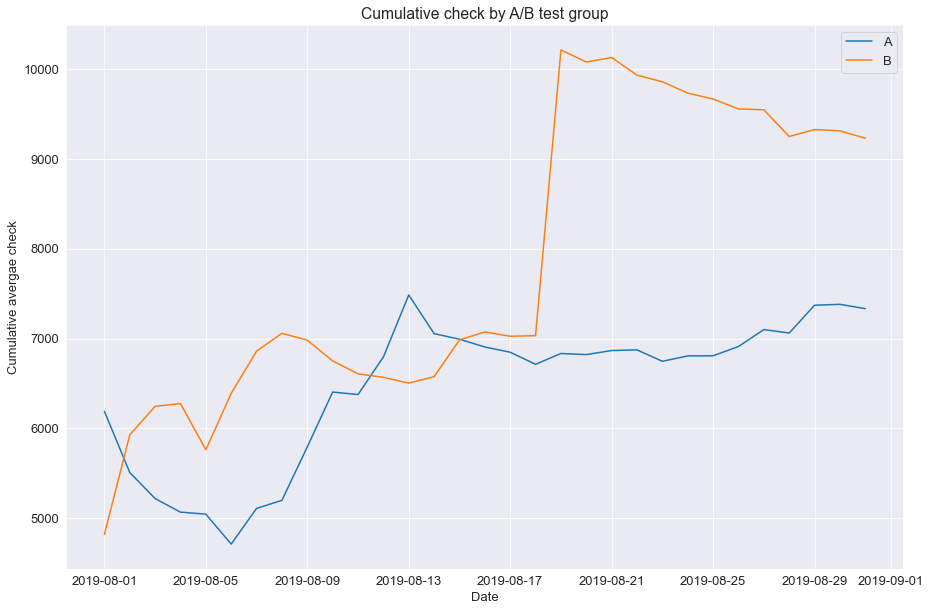

In [31]:
plt.figure(figsize=(15,10))
plt.plot(
    cumulativeRevenueA['date'], 
    cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 
    label='A')
plt.plot(
    cumulativeRevenueB['date'], 
    cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 
    label='B')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative avergae check')
plt.title('Cumulative check by A/B test group')
plt.show()

The average check for group A becomes more uniform towards the end of the test, at the initial stage of the test there are points of decline and growth. The cumulative average check for group B increases sharply at one point and then begins to decline towards the end of the test. This may indicate that there is a very expensive order on that date. We will return to this when analyzing outliers.

Let's plot the relative difference for the cumulative average ticket.

In [32]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', right_on='date', 
    how='left', 
    suffixes=['A', 'B'])

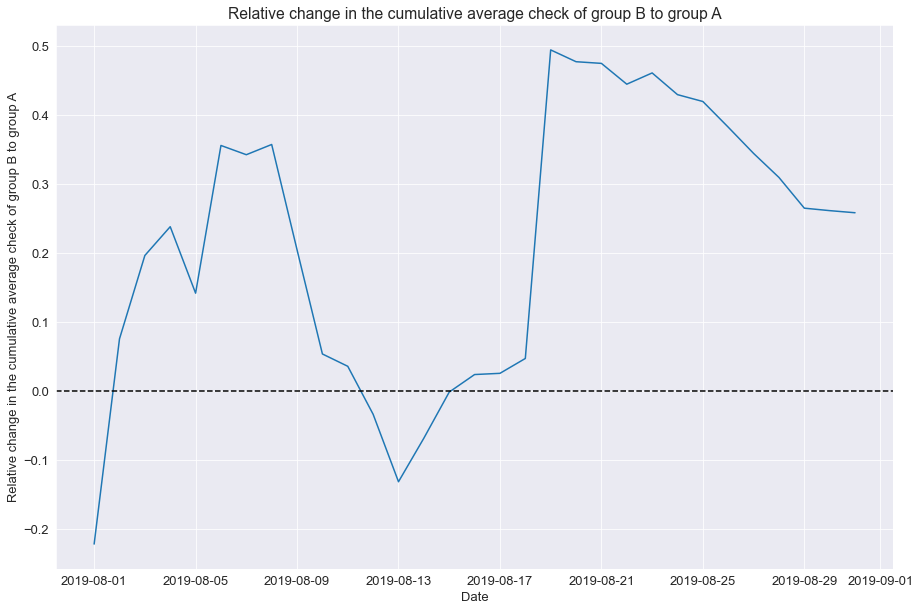

In [33]:
plt.figure(figsize=(15,10))
plt.plot(
    mergedCumulativeRevenue['date'], 
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
    (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, 
            color='black', 
            linestyle='--')
plt.xlabel('Date')
plt.ylabel('Relative change in the cumulative average check of group B to group A')
plt.title('Relative change in the cumulative average check of group B to group A')
plt.show()

The graph of the difference in the cumulative average check between groups changes dramatically at several points, which can be explained by outliers.

Let's build a graph of cumulative conversion and a graph of the relative change in the cumulative conversion of group B to group A.

In [34]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

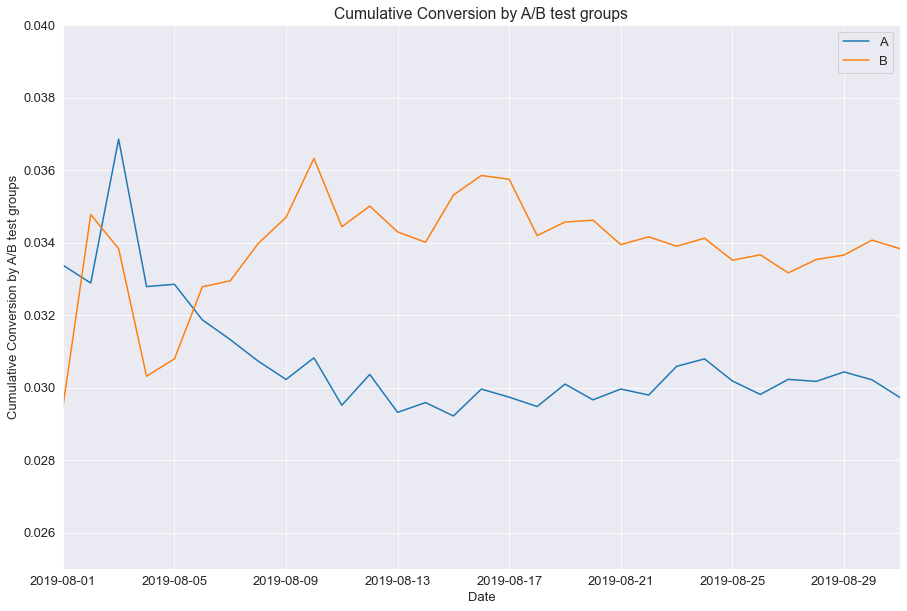

In [41]:
plt.figure(figsize=(15,10))
plt.plot(cumulativeDataA['date'], 
         cumulativeDataA['conversion'], 
         label='A')
plt.plot(cumulativeDataB['date'], 
         cumulativeDataB['conversion'], 
         label='B')
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0.025, 0.040])
plt.xlabel('Date')
plt.ylabel('Cumulative Conversion by A/B test groups')
plt.title('Cumulative Conversion by A/B test groups')
plt.show()

The plot of cumulative conversion by A/B test groups is symmetrical. At the beginning of the test, groups fluctuated around one value, but then the conversion of group A dipped and fixed, while the conversion of group B increased and also fixed.

In [42]:
mergedCumulativeConversions = (
    cumulativeDataA[['date','conversion']]
    .merge(
        cumulativeDataB[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B']))

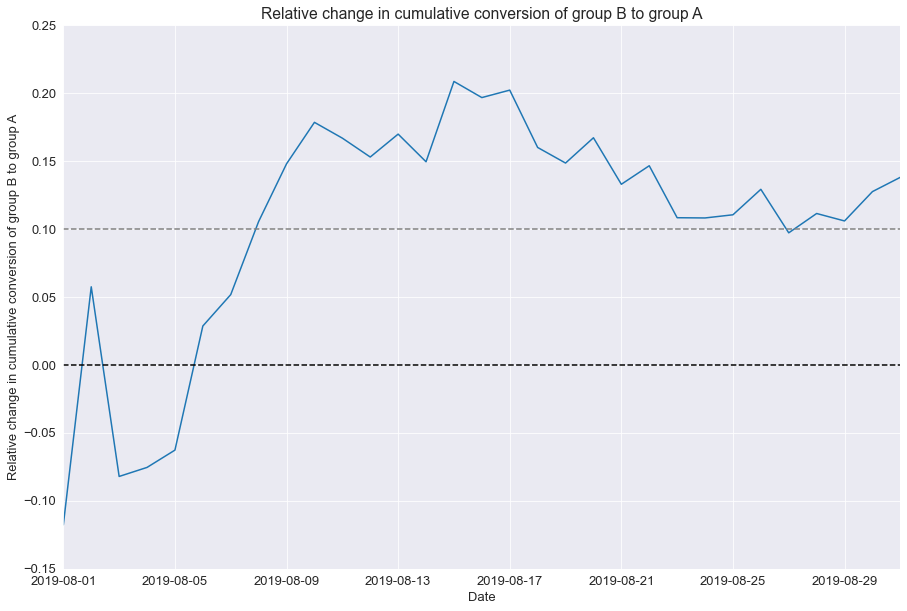

In [43]:
plt.figure(figsize=(15,10))
plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.xlabel('Date')
plt.ylabel('Relative change in cumulative conversion of group B to group A')
plt.title("Relative change in cumulative conversion of group B to group A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.10, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.15, 0.25])
plt.show()

At the beginning of the test, group B was significantly behind group A, then it significantly pulled ahead. Toward the end of the test, the conversion of the group began to fall, but it still exceeded the conversion of group A. In general, the conversion ratio began to stabilize towards the end of the test.

### Conclusion on Cummulative indicators
- Group B's cumulative revenue at the end of the test is higher than group A's. Group A's revenue growth is relatively stable, while group B's has a sharp jump that can be explained by outliers. The plot of the difference in the cumulative average check between groups changes dramatically at several points.
- At the beginning of the test, the conversion values in the groups were similar, but by the end of the test, the conversion of group A dipped and fixed, while the conversion of group B increased and also fixed, respectively, at a higher level. The ratio of group B conversion to group A conversion began to stabilize towards the end of the test.

## Outlier Analysis

Let's build a plot of the number of orders by user.

In [44]:
ordersByUsers = (
    orders
    .drop(
        ['group', 
         'revenue', 
         'date'],
        axis=1)
    .groupby(
        'visitorId', 
        as_index=False)
    .agg(
        {'transactionId' : pd.Series.nunique}))

ordersByUsers.columns = ['visitorId',
                         'orders']

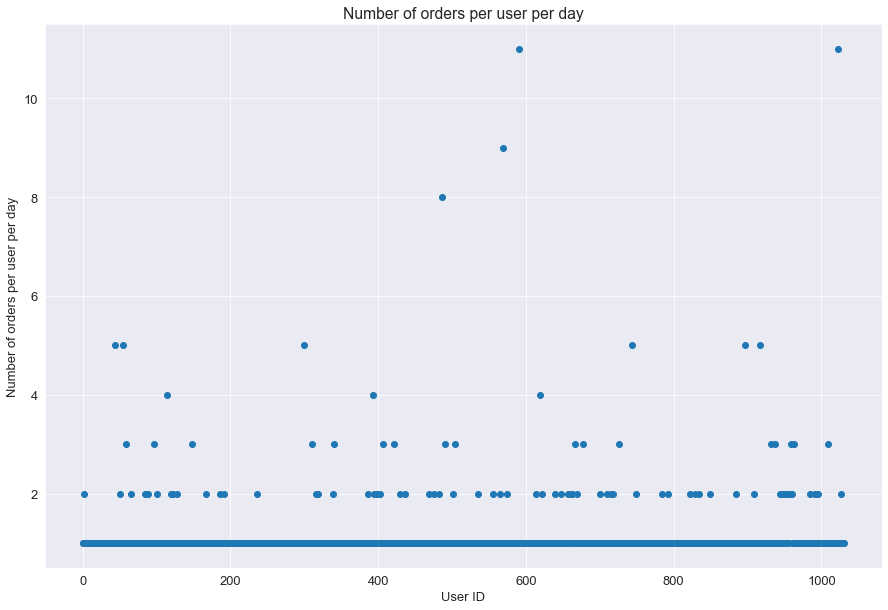

In [45]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(15,10))
plt.scatter(x_values, 
            ordersByUsers['orders'])
plt.grid(True)
plt.xlabel('User ID')
plt.ylabel('Number of orders per user per day')
plt.title('Number of orders per user per day')
plt.show()

Most users make up to two orders per day, while there are users who make more than 10 orders per day. Let's calculate the 95th and 99th percentiles of orders per user. Let's choose a boundary to determine anomalous users.

In [46]:
print('95th percentile of orders per user: {0:.0f}; 99th percentile of orders per user: {1:.0f}.'
      .format(np.percentile(ordersByUsers['orders'], [95, 99])[0],
              np.percentile(ordersByUsers['orders'], [95, 99])[1]))

95th percentile of orders per user: 2; 99th percentile of orders per user: 4.


Let's choose 4 orders per user as the limit of the number of orders, and remove anomalous users using it.

Let's build a plot and analyze order revenues.

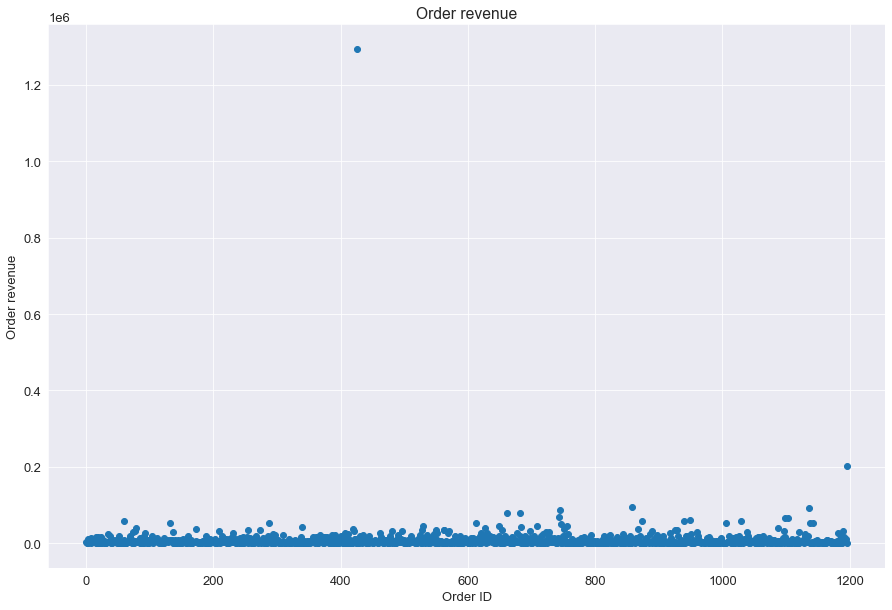

In [47]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,10))
plt.scatter(x_values, 
            orders['revenue'])
plt.grid(True)
plt.xlabel('Order ID')
plt.ylabel('Order revenue')
plt.title("Order revenue")
plt.show()

The order cost chart shows two outliers: an order with revenue of about 200,000 and an order with revenue of about 1,200,000.
Let's build a separate plot for orders that worth less than 200,000 in order to more clearly track the border for the abnormal revenue.

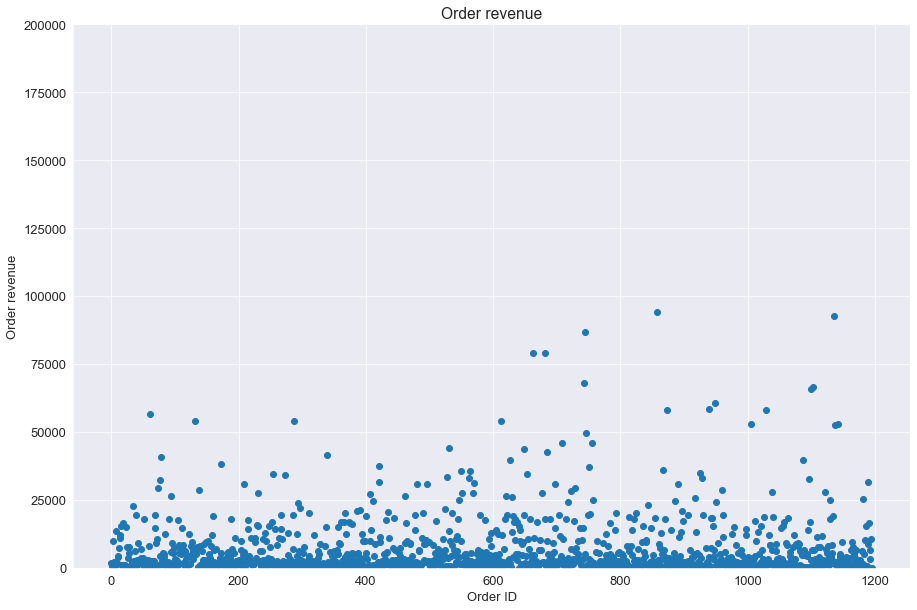

In [48]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,10))
plt.scatter(x_values, 
            orders['revenue'])
plt.ylim(0, 200000)
plt.grid(True)
plt.xlabel('Order ID')
plt.ylabel('Order revenue')
plt.title("Order revenue")
plt.show()

Let's calculate the 95th and 99th percentiles of order revenues and choose a boundary to detect anomalous orders.

In [49]:
print('95th percentile of oreder revenue: {0:.0f}; 99th percentile of oreder revenue: {1:.0f}.'
      .format(np.percentile(orders['revenue'], [95, 99])[0],
              np.percentile(orders['revenue'], [95, 99])[1]))

95th percentile of oreder revenue: 28000; 99th percentile of oreder revenue: 58233.


Let's choose a limit for detecting anomalous orders: 50 000.

### Conclusion on Outlier Analysis

Limits were set to determine the anomalous number of orders per user - 4 (we remove 1% of users with the largest number of orders) and the anomalous order revenue - 50 000 (we remove from 5% to 1% of the most expensive orders).

## Test for Statistical Significance

Let's collect the data necessary for the test of the statistical significance of A/B test into the `data` dataframe.

In [50]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 
                                                   'visitors']]
visitorsADaily.columns = ['date', 
                          'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
    .agg({'date' : 'max', 
          'visitorsPerDateA' : 'sum'}), 
    axis=1)
visitorsACummulative.columns = ['date', 
                                'visitorsCummulativeA']
visitorsBDaily = visitors[visitors['group']=='B'][['date', 
                                                   'visitors']]
visitorsBDaily.columns = ['date', 
                          'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
    .agg({'date' : 'max', 
          'visitorsPerDateB' : 'sum'}), 
    axis=1)
visitorsBCummulative.columns = ['date', 
                                'visitorsCummulativeB']

In [51]:
ordersADaily = (
    orders[orders['group']=='A'][['date', 
                                  'transactionId', 
                                  'visitorId', 
                                  'revenue']]
    .groupby('date', 
             as_index=False)
    .agg({'transactionId' : pd.Series.nunique, 
          'revenue' : 'sum'}))
ordersADaily.columns = ['date', 
                        'ordersPerDateA', 
                        'revenuePerDateA']
ordersACummulative = (
    ordersADaily.apply(
        lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
        .agg({'date' : 'max',
              'ordersPerDateA' : 'sum',
              'revenuePerDateA' : 'sum'}), 
        axis=1)
    .sort_values(by=['date']))
ordersACummulative.columns = ['date', 
                              'ordersCummulativeA', 
                              'revenueCummulativeA']
ordersBDaily = (
    orders[orders['group']=='B'][['date', 
                                  'transactionId', 
                                  'visitorId', 
                                  'revenue']]
    .groupby('date', 
             as_index=False)
    .agg({'transactionId' : pd.Series.nunique, 
          'revenue' : 'sum'}))
ordersBDaily.columns = ['date', 
                        'ordersPerDateB', 
                        'revenuePerDateB']
ordersBCummulative = (
    ordersBDaily.apply(
        lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
        .agg({'date' : 'max',
              'ordersPerDateB' : 'sum',
              'revenuePerDateB' : 'sum'}), 
        axis=1)
    .sort_values(by=['date']))
ordersBCummulative.columns = ['date', 
                              'ordersCummulativeB', 
                              'revenueCummulativeB']

In [52]:
data = (
    ordersADaily
    .merge(
        ordersBDaily, 
        left_on='date', 
        right_on='date', 
        how='left')
    .merge(
        ordersACummulative, 
        left_on='date', 
        right_on='date', 
        how='left')
    .merge(
        ordersBCummulative, 
        left_on='date', 
        right_on='date', 
        how='left')
    .merge(
        visitorsADaily, 
        left_on='date', 
        right_on='date', 
        how='left')
    .merge(
        visitorsBDaily, 
        left_on='date', 
        right_on='date', 
        how='left')
    .merge(
        visitorsACummulative, 
        left_on='date', 
        right_on='date', 
        how='left')
    .merge(
        visitorsBCummulative, 
        left_on='date', 
        right_on='date', 
        how='left'))
display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Let's evaluate the statistical significance of differences in conversion and average check between test groups according to "raw" data (before removing outliers).

In [53]:
ordersByUsersA = (
    orders[orders['group']=='A']
    .groupby('visitorId', 
             as_index=False)
    .agg({'transactionId' : pd.Series.nunique}))
ordersByUsersA.columns = ['visitorId', 
                          'orders']
ordersByUsersB = (
    orders[orders['group']=='B']
    .groupby('visitorId', 
             as_index=False)
    .agg({'transactionId' : pd.Series.nunique}))
ordersByUsersB.columns = ['visitorId', 
                          'orders']

In [54]:
sampleA = pd.concat(
    [ordersByUsersA['orders'],
     pd.Series(0, 
               index=np.arange(data['visitorsPerDateA'].sum() - 
                               len(ordersByUsersA['orders'])), 
               name='orders')],
    axis=0)
sampleB = pd.concat(
    [ordersByUsersB['orders'],
     pd.Series(0, 
               index=np.arange(data['visitorsPerDateB'].sum() - 
                               len(ordersByUsersB['orders'])), 
               name='orders')]
    ,axis=0)
sampleA.name = 'A'
sampleB.name = 'B'

To choose a statistical criterion for testing, we need to find out whether the distribution of the variable is normal in both samples.
Let's apply the Shapiro-Wilk test, taking the critical level of statistical significance equal to 0.05.

In [58]:
for sample in (sampleA, sampleB):
    alpha = .05
    results = stats.shapiro(sample)
    p_value = results[1]
    print('p-value for sample {0} (conversion): {1:.3f}'.format(sample.name, p_value))
    if (p_value < alpha):
        print("Distribution is not normal")
    else:
        print("Distribution is normal")

p-value for sample A (conversion): 0.000
Distribution is not normal
p-value for sample B (conversion): 0.000
Distribution is not normal


The distribution is not normal, so a non-parametric test must be applied. Let's use the Mann-Whitney test.

Let's formulate the null and alternative hypotheses:
- **H0: there are no statistically significant differences in conversion between groups A and B in raw data**
- **H1: there are statistically significant differences in conversion between groups A and B in raw data**

Let's take the critical level of statistical significance equal to 0.05.

In [59]:
print(
    "p-value = {0:.3f}"
    .format(stats.mannwhitneyu(
        sampleA, 
        sampleB)
            [1]))
print(
    "Group B relative gain: {0:.1%}"
    .format(sampleB.mean()/
            sampleA.mean()-1))

p-value = 0.008
Group B relative gain: 13.8%


The calculated p-value = 0.008 is less than 0.05. This means that the hypothesis **H0** that there are no statistically significant differences in conversion between groups can be rejected. Group B's relative gain is 13.8%.

Let's test the statistical significance of the differences in the average check between the testing groups according to the "raw" data.

Let's find out if the distribution of the variable is normal in two samples. Let's apply the Shapiro-Wilk test, taking the critical level of statistical significance equal to 0.05.

In [60]:
for group in ('A', 'B'):
    alpha = .05
    results = stats.shapiro(orders[orders['group']==group]['revenue'])
    p_value = results[1]
    print('p-values for sample {0} (average check): {1:.3f}'.format(sample.name, p_value))
    if (p_value < alpha):
        print("Distribution is not normal")
    else:
        print("Distribution is normal")    

p-values for sample B (average check): 0.000
Distribution is not normal
p-values for sample B (average check): 0.000
Distribution is not normal


The distribution is not normal, so a non-parametric test must be applied. Let's use the Mann-Whitney test.

Let's formulate the null and alternative hypotheses:
- **H0: there are no statistically significant differences in average check between groups A and B in raw data**
- **H1: there are statistically significant differences in average check between groups A and B in raw data**

Let's take the critical level of statistical significance equal to 0.05.

In [61]:
print(
    "p-value = {0:.3f}"
    .format(
        stats.mannwhitneyu(
            orders[orders['group']=='A']['revenue'], 
            orders[orders['group']=='B']['revenue'])
        [1]))
print(
    "Group B relative gain: {0:.1%}"
    .format(orders[orders['group']=='B']['revenue'].mean()/
            orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.365
Group B relative gain: 25.9%


P-value = 0.365 is greater than 0.05. Hence, there is no reason to reject the hypothesis H0 that there are no statistically significant differences in the average check between groups. The relative gain of group B is 25.9%.

Let's test the statistical significance of differences in conversion between groups according to "cleaned" data (after removing outliers).

Let's estimate the total number of anomalous users.

In [62]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'], 
     ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId']], 
    axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitorId']
abnormalUsers = (
    pd.concat(
        [usersWithManyOrders, 
         usersWithExpensiveOrders], 
        axis = 0)
    .drop_duplicates())
print('Number of anomalous users: {}'
      .format(abnormalUsers.shape[0]))

Number of anomalous users: 21


Let's evaluate how the actions of 21 anomalous users affected the test results.

Let's evaluate the statistical significance of the differences in conversion based on the "cleaned" data.

Let's formulate the null and alternative hypotheses:
- **H0: there are no statistically significant differences in conversion between groups A and B in cleaned data**
- **H1: there are statistically significant differences in conversion between groups A and B in cleaned data**

Let's take the critical level of statistical significance equal to 0.05.

In [66]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(
        ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
     pd.Series(
         0, 
         index=np.arange(
             data['visitorsPerDateA'].sum() -
             len(ordersByUsersA['orders'])),
         name='orders')],
    axis=0)
sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(
        ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
     pd.Series(
         0, 
         index=np.arange(data['visitorsPerDateB'].sum() - 
                         len(ordersByUsersB['orders'])),
         name='orders')],
    axis=0)

In [67]:
print(
    "p-value = {0:.3f}"
    .format(stats.mannwhitneyu(
        sampleAFiltered, 
        sampleBFiltered)
            [1]))
print(
    "Group B relative gain: {0:.1%}"
    .format(sampleBFiltered.mean()/
            sampleAFiltered.mean()-1))

p-value = 0.006
Group B relative gain: 16.0%


P-value = 0.006 is less than 0.05. This means that the null hypothesis that there are no statistically significant differences in conversion between groups can be rejected. Group B's relative gain is 16.0%.

Let's evaluate the statistical significance of the differences in average check based on the "cleaned" data

Let's formulate the null and alternative hypotheses:
- **H0: there are no statistically significant differences in average check between groups A and B in cleaned data**
- **H1: there are statistically significant differences in average check between groups A and B in cleaned data**

Let's take the critical level of statistical significance equal to 0.05.

In [69]:
print(
    "p-value = {0:.3f}"
    .format(
        stats.mannwhitneyu(
            orders[np.logical_and(
                orders['group']=='A',
                np.logical_not(
                    orders['visitorId'].isin(abnormalUsers)))]['revenue'],
            orders[np.logical_and(
                orders['group']=='B',
                np.logical_not(
                    orders['visitorId'].isin(abnormalUsers)))]['revenue'])
        [1]))
print(
    "Group B relative gain: {0:.1%}"
    .format(
        orders[np.logical_and(
            orders['group']=='B',
            np.logical_not(
                orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
        orders[np.logical_and(
            orders['group']=='A',
            np.logical_not(
                orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value = 0.358
Group B relative gain: 3.2%


P-value = 0.358 is greater than 0.05. Hence, there is no reason to reject the null hypothesis that there are no statistically significant differences in the average check between groups. The relative gain of group B is 3.2%.

### Conclusion on Test for Statistical Significance

* The difference in conversion between groups is statistically significant for both "raw" and "cleaned" data. The relative gain of group B is 13.8% in the first case and 15.5% in the second case.

* The difference in the average check between the groups turned out to be statistically insignificant both in the case of "raw" and in the case of "cleaned" data. The relative gain of group B in the first case is 25.9%, while in the second case it is only 3.2%. Thus, the relative gain of group B in the case of "raw" data is explained mainly by the presence of outliers.


> Decision: Stop the test, record the victory of group B.

Group B is statistically significantly better than group A in terms of conversion, and the conversion plot indicates a fixation of the result. It was not possible to establish statistically significant differences between the amounts of the average check in the groups.

## Conclusion

The analysis of the A/B test results was carried out for two indicators: conversion and average check. No gaps, duplicates or any other errors were found in the data.

- Group B's cumulative revenue at the end of test is higher than group A's. Group A's revenue growth is relatively stable, while group B's has a sharp jump that can be explained by outliers. The plot of the difference in the cumulative average check between groups changes dramatically at several points. At the initial stage, the conversion values in the groups were similar, but by the end of the test, the conversion of group A dipped and fixed, while the conversion of group B increased and also fixed, respectively, at a higher level. The ratio of group B conversion to group A conversion began to stabilize towards the end of the test.

- As a result of the analysis of outliers, limits were set to determine the abnormal number of orders per user - 4 (we remove 1% of users with the largest number of orders) and the abnormal order value - 50 thousand (we remove from 5% to 1% of the most expensive orders).  

- The difference in conversion between groups is statistically significant for both raw and cleaned data. The relative gain of group B is 13.8% in the first case and 15.5% in the second case. The difference in the average check between the groups turned out to be statistically insignificant both in the case of "raw" and in the case of "cleaned" data. The relative gain of group B in the first case was 25.9%, while in the second it was only 3.2%. Thus, the relative gain of group B in the case of "raw" data can be explained mainly by the presence of outliers.

- Based on the results of the analysis, it was decided to stop the test and record the victory of group B. Group B is statistically significantly better than group A in terms of conversion, and the conversion graph indicates that the result is fixed. It was not possible to establish statistically significant differences between the amounts of the average check in the groups.